In [1]:
using Pkg
Pkg.activate(@__DIR__)
push!(LOAD_PATH, joinpath(@__DIR__, "..", ".."));

In [2]:
using JuMP
using BARON
using CouenneNL
using LinearAlgebra
using Parameters
using MINLPTrajOpt
using MINLPTrajOpt.Acrobot

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.0/MINLPTrajOpt/myGxE.ji for MINLPTrajOpt [c68a6224-cbe5-11e8-1e7f-b1d3117b2aa4]
└ @ Base loading.jl:1184


In [3]:
rootdir = joinpath(dirname(pathof(MINLPTrajOpt)), "..")
save_data = true;

The optimizer is clearly exploiting numerical issues due to the primitive integration scheme, injecting energy by searching for instability.

TODO:

* Running state cost
* AxisArrays for sanity
* Better discretization of the continuous time dynamics
* Think about better integration schemes
  * Central differencing for accelerations
  * Semi-implicit Euler
  * Energy flow constraints
  * Variable time steps
* Keep track of total energy
* Compare to COUENNE

In [7]:
solver = BaronSolver(threads=Sys.CPU_THREADS)
# solver = CouenneNLSolver()
parameters = AcrobotParameters()
τmax = 20.0
θ10 = 0.1
θ1d0 = 0.0
θ20 = 0.0
θ2d0 = 0.0

# N = 40
# objectivetype = MinTime()
# fixedstep = false
# T = nothing

N = 40
objectivetype = MinEffort()
fixedstep = true
T = 4.0

if fixedstep
    Δt = T / N
    Δtmin = Δt
    Δtmax = Δt
else
    Δtmin = 0.0
    Δtmax = 0.5
end

problem = AcrobotSwingUpProblem(parameters, (θ10, θ1d0, θ20, θ2d0), solver;
    τmax=τmax, Δtmin=Δtmin, Δtmax=Δtmax, T=T, N=N, objectivetype=objectivetype);

In [8]:
status = solve(problem.model)
@assert status == :Optimal

 BARON version 18.8.23. Built: LNX-64 Thu Aug 23 14:46:44 EDT 2018

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: MIT at Twan Koolen, tkoolen@mit.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP: ILOG CPLEX                                      
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Using CPLEX library libcplex1280.so.
 Preprocessing found feasible solution with value  3592.94511424     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s) 

In [9]:
if save_data
    i = 0
    while (datadir = joinpath(rootdir, "data", "acrobot", "run$i"); isdir(datadir))
        i += 1
    end
    mkpath(datadir)
end
if save_data && solver isa BaronSolver
    cp(problem.model.internalModel.options[:SumName], joinpath(datadir, "sum.lst"))
end

"/home/twan/code/julia-projects/MINLPTrajOpt/src/../data/acrobot/run0/sum.lst"

In [11]:
push!(LOAD_PATH, joinpath(@__DIR__, "..", "..", "extras", "PlottingTools"))
using PlottingTools
using PlottingTools.LaTeXStrings
using PlottingTools.PGFPlotsX
PGFPlotsX.latexengine!(PGFPlotsX.PDFLATEX)

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.0/PlottingTools/V0GtG.ji for PlottingTools [b508c106-e140-11e8-0f59-d335704603d2]
└ @ Base loading.jl:1184


PDFLATEX::LaTeXEngine = 1

In [12]:
t = [0.0; cumsum(getvalue.(problem.Δt))]
Δθ1 = atan.(getvalue.(problem.sΔθ1) ./ getvalue.(problem.cΔθ1))
θ1 = θ10 .+ [0.0; cumsum(Δθ1)]
τ = getvalue.(problem.τ)
θ1dd = getvalue.(problem.θ1dd);
Δθ2 = atan.(getvalue.(problem.sΔθ2) ./ getvalue.(problem.cΔθ2))
θ2 = θ20 .+ [0.0; cumsum(Δθ2)]
τ = getvalue.(problem.τ)
θ2dd = getvalue.(problem.θ2dd);

In [13]:
if save_data
    open(joinpath(datadir, "settings.txt"), write=true) do io
        println(io, "N = $N")
        println(io, "θ10 = $θ10")
        println(io, "θ1d0 = $θ1d0")
        println(io, "θ20 = $θ20")
        println(io, "θ2d0 = $θ2d0")
        println(io, "solver = $solver")
        println(io, "status = $status")
        println(io, "solvetime = $(getsolvetime(problem.model))")
        println(io)
    end
end

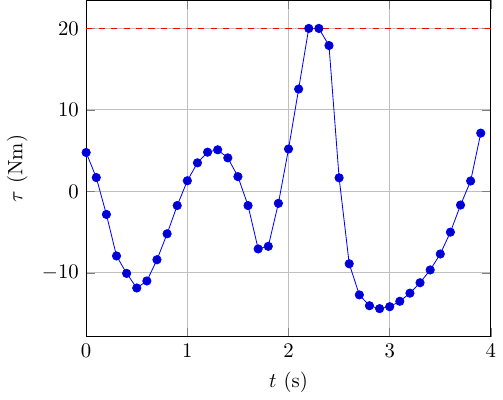

In [14]:
p = timeplot(t[1 : end - 1], τ; ylabel=L"$\tau$ (Nm)", tmax=t[end])
push!(p, @pgf HLine({dashed, red, thick}, τmax))
push!(p, @pgf HLine({dashed, red, thick}, -τmax))
save_data && pgfsave(joinpath(datadir, "tau.pdf"), p)
p

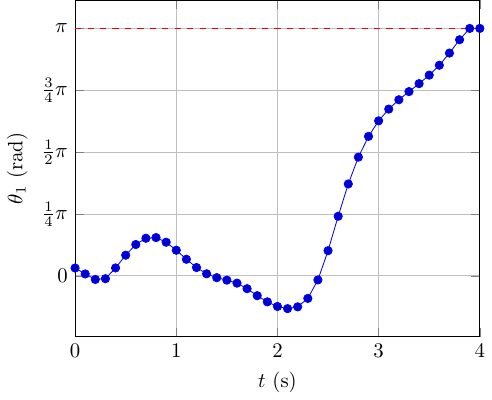

In [15]:
p = timeplot(t, θ1; ylabel=L"$\theta_1$ (rad)")
push!(p, @pgf HLine({dashed, red, thick}, Float64(π)))
piticks!(p, 1//4, θ1; axis=:y)
save_data && pgfsave(joinpath(datadir, "theta1.pdf"), p)
p

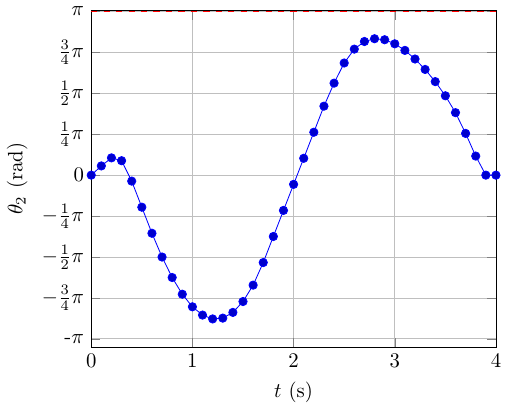

In [16]:
p = timeplot(t, θ2; ylabel=L"$\theta_2$ (rad)")
push!(p, @pgf HLine({dashed, red, thick}, Float64(π)))
piticks!(p, 1//4, θ2; axis=:y)
save_data && pgfsave(joinpath(datadir, "theta2.pdf"), p)
p
# UPDATED UNTIL HERE